## Data Generation
Author: Allen Ross  
Date: 05/13/21   
In this notebook we will be generating some data from known kernels to test kernel learning methods.

In [1]:
# Libraries
import gpflow
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from gpflow.utilities import print_summary
from helper_functions import Categorical, calc_bic

# Figure options
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
mpl.rcParams['axes.linewidth'] = 0.25
# set tick width
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = .5
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.width'] = .25
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = .5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.width'] = .25

Generate X design matrix

In [2]:
## Specify data generating parameters
# Set seed for reproducibility
np.random.seed(9012)

# Number of individual units
num_units = 10

# Assign treatment group to each unit
# treat_group = np.repeat([0,1], num_units/2)
treat_group = np.random.binomial(n=1, p=0.5, size=num_units)

# Sample number of observations for each unit
num_obs = np.random.poisson(lam=12, size=num_units)

# Sample from uniform distribution for observation times
x = np.concatenate(
    [np.sort(np.round(np.random.uniform(low=0, high=12, size=i),1)) for i in num_obs],
    axis=0)

# Put unit ID and observation time together
df = np.array([np.repeat(np.arange(num_units), num_obs),
               np.repeat(treat_group, num_obs),
               x]).T
print('Size of observation set:', df.shape)
df[:5,]

Size of observation set: (126, 3)


array([[0. , 0. , 0. ],
       [0. , 0. , 1.4],
       [0. , 0. , 2. ],
       [0. , 0. , 2.4],
       [0. , 0. , 3.4]])

In [3]:
# Create range for simulated set as well
sim_x = np.arange(start=0, stop=12, step=0.1)
df_sim = np.hstack((np.repeat(np.arange(num_units), len(sim_x))[:, None],
               np.repeat(treat_group, len(sim_x))[:, None],
               np.tile(np.round(sim_x,2), reps=num_units)[:, None]))

# Get proper index of observed rows
obs_idx = (np.concatenate([np.where((df_sim == df[i,:]).sum(axis=1) == 3) 
                           for i in range(df.shape[0])]).flatten())

print('Size of simulation set:', df_sim.shape)
df_sim[:5,]

Size of simulation set: (1200, 3)


array([[0. , 0. , 0. ],
       [0. , 0. , 0.1],
       [0. , 0. , 0.2],
       [0. , 0. , 0.3],
       [0. , 0. , 0.4]])

### Kernels

#### Kernel 1: individual offset + matern32 over time
This kernel represents a biological process that has differening individual levels, but across individuals there is a conserved dynamic process occuring. An example of what this might represent is a metabolite that is tied to specific time-dependent events that are similar across individuals (e.g. holidays or large gatherings might produce these effects).

#### Kernel 2: individual offset + individual * squaredexp over time + periodic over time
This kernel represents a biological process that also has differing individual level offsets, individual-specific time components, and an overall periodic process occuring across all individuals. This might represent a metabolite that has a seasonal effect but also depends on a particular individuals behaviors and habits over time. 

#### Kernel 3: individual offset + linear treatment effect
This kernel represents a linear treatment effect over time, where each individual has a different baseline value. This might represent a particular metabolite value that differs by person, but also is affected by a given treatment over time. 

#### Kernel 4: individual offset + polynomial treatment effect + individual * matern32 over time
This kernel represents a nonlinear treatment effect but it is also confounded by the fact that the feature is also changing naturally over time.

In [4]:
## Specify kernels
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern12(variance=1.0, 
                              lengthscales=1.0, 
                              active_dims=[2]) + 
      Categorical(variance=2.0,
                  active_dims=[0]))

# Second kernel is random unit specfic effect + time varying unit specific effect + 
# periodic overall effect
k2 = (#Categorical(variance=0.5,
      #            active_dims=[0]) + 
      gpflow.kernels.Matern12(variance=1., #0.5 
                                        lengthscales=0.5, 
                                        active_dims=[2]) * 
     Categorical(active_dims=[0]) + 
     gpflow.kernels.Periodic(
         base_kernel=gpflow.kernels.SquaredExponential(
             variance=2., active_dims=[2]), # variance=2.5
         period=3.0))

# Third kernel is random unit specific effect + treatment effect
k3 = (Categorical(active_dims=[0], variance=0.5) + 
      Categorical(active_dims=[1]) * 
      gpflow.kernels.Linear(variance=0.1, 
                            active_dims=[2]))

# Fourth kernel is unit specific effect + changepoint (M32/M32)
# k4 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
#       gpflow.kernels.ChangePoints(kernels = [gpflow.kernels.Matern32(variance=5.0,lengthscales=0.5,active_dims=[2]),
#                                              gpflow.kernels.Matern32(variance=1.0,lengthscales=2.5,active_dims=[2])],
#                                   locations = [3],
#                                   steepness=1.0))
## Can't use changepoint model at the moment, as GPflow doesn't allow for multidimension CP kernels

# Fourth kernel is random unit effect + nonlinear random treatment effect over time + 
# nonlinear individual effect over time
k4 = (#Categorical(active_dims=[0]) + 
      Categorical(active_dims=[1], variance=0.001) * 
      gpflow.kernels.Polynomial(degree=2, 
                                offset=3., #0.05, 
                                variance=1., #0.05, 
                                active_dims=[2]) + 
#       gpflow.kernels.Linear(active_dims=[2]) + 
      Categorical(active_dims=[0]) *
      # gpflow.kernels.Matern12(variance=1.0, 
      #                         lengthscales=3.0, 
      #                         active_dims=[2]) + 
      gpflow.kernels.SquaredExponential(variance=2.,
                                        lengthscales=0.5,
                                        active_dims=[2]))


# Kernel dictonary
kern_out = {'y1': {'model': k1},
            'y2': {'model': k2},
            'y3': {'model': k3},
            'y4': {'model': k4}}

2021-12-26 13:20:29.728054: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sampling from kernel y1
Sampling from kernel y2
Sampling from kernel y3
Sampling from kernel y4


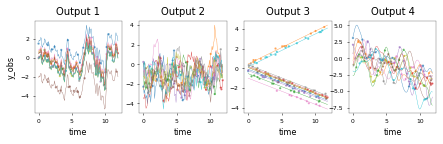

In [5]:
np.random.seed(9102)
# Specify plot object
f, axs = plt.subplots(1, len(kern_out), figsize=(7.2,1.7))
ic = 0
# Prepare data for plotting
df_plot = pd.DataFrame(df, 
                       columns=['unit','treatment','time'])
df_plot.unit = df_plot.unit.astype('category')
# df_plot.time = (df_plot.time - df_plot.time.mean())/df_plot.time.std()

df_sim_plot = pd.DataFrame(df_sim, 
                       columns=['unit','treatment','time'])
df_sim_plot.unit = df_sim_plot.unit.astype('category')
# df_sim_plot.time = (df_sim_plot.time - df_sim_plot.time.mean())/df_sim_plot.time.std()

# Sample from kernels
for k in kern_out.keys():
    np.random.seed(9012)
    print('Sampling from kernel {}'.format(k))
    kern_out[k]['f_true'] = np.random.multivariate_normal(
        np.zeros_like(df_sim[:,0]).flatten(),
        kern_out[k]['model'](df_sim) + 1e-6*np.eye(df_sim.shape[0]),
        1
    )
    
    kern_out[k]['y_obs'] = (kern_out[k]['f_true'][0,obs_idx] + 
                            np.random.normal(scale=0.1, size=len(df)))
    
    # Plot resulting output
    df_sim_plot = df_sim_plot.assign(f_true = kern_out[k]['f_true'].flatten())
    df_plot = df_plot.assign(y_obs = kern_out[k]['y_obs'].flatten())
    p = sns.scatterplot(data=df_plot,
                        x='time',
                        y='y_obs',
                        hue='unit',
                        linewidths = 0.05,
                        s=5,
                        alpha=0.7,
                        legend=False,
                        ax=axs[ic])
    p = sns.lineplot(data=df_sim_plot,
                     x='time',
                     y='f_true',
                     hue='unit',
                     legend=False,
                     alpha=0.9,
                     linewidth=0.35,
                     ax=axs[ic])
    p.set_title('Output {}'.format(ic+1))
    if ic != 0:
        p.set_ylabel('')
    p.plot();
    
    ic += 1
    
# f_true = np.random.multivariate_normal(
#     np.zeros_like(df[:,0]).flatten(),
#     k1(df),
#     1
# )
# y_true = f_true + np.random.normal(scale=1)

# for i in range(num_units):
# #     plt.plot(x, y_true[i,:], 'x')
#     plt.plot(x, y_true[i,:], 'b')

# plt.plot(df[:,2], f_true.T, 'x')
# plt.plot(x, y_true.T);

In [6]:
plt.tight_layout()
f.savefig('../figures/kernels.pdf', dpi=350, bbox_inches = "tight") 
f.savefig('../figures/Kernels.png', dpi=350, bbox_inches = "tight")
plt.close()

In [7]:
# Drop plotting column
df_plot.drop(columns=['y_obs'], inplace=True)
for k in kern_out.keys():
    df_plot[k+'_obs'] = np.round(kern_out[k]['y_obs'], 2)
df_plot.head()

,unit,treatment,time,y1_obs,y2_obs,y3_obs,y4_obs
0,0.0,0.0,0.0,1.51,-2.29,-0.27,3.07
1,0.0,0.0,1.4,1.35,-2.21,-0.43,2.83
2,0.0,0.0,2.0,0.90,-1.52,-0.70,0.01
3,0.0,0.0,2.4,1.18,0.67,-0.89,0.16
4,0.0,0.0,3.4,0.85,-1.68,-0.97,0.92


In [8]:
# Save output data
df_plot.to_csv('simulated_data.csv', index=False)

In [9]:
df_sim_plot.drop(columns=['f_true'], inplace=True)
for k in kern_out.keys():
    df_sim_plot[k+'_true'] = np.round(kern_out[k]['f_true'][0,:], 2)
df_sim_plot.head()

,unit,treatment,time,y1_true,y2_true,y3_true,y4_true
0,0.0,0.0,0.0,1.71,-2.09,-0.08,3.27
1,0.0,0.0,0.1,1.88,-2.98,-0.10,3.68
2,0.0,0.0,0.2,1.77,-2.58,-0.13,4.11
3,0.0,0.0,0.3,2.14,-3.47,-0.16,4.52
4,0.0,0.0,0.4,2.10,-3.40,-0.19,4.84


In [10]:
# Save full output data
df_sim_plot.to_csv('simulated_data_full.csv', index=False)

Calculate what the **best** BIC possible is

In [11]:
from scipy.stats import multivariate_normal
k1_mvn = multivariate_normal(
    mean=np.zeros((df_plot.shape[0],)),
    cov=k1(df_plot[['unit','treatment','time']]) + np.eye(df_plot.shape[0])*1e-2
)
k1_loglik = k1_mvn.logpdf(df_plot['y1_obs'])
k1_bic = calc_bic(
    loglik=k1_loglik, 
    n=df_plot.shape[0], 
    k=len(k1.trainable_parameters)
)
k1_bic

2021-12-26 13:20:37.385569: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


169.71614261744028

Let's do this process for multiple rates and varying noise in likelihood

In [12]:
def sim_data(rate=12, num_units=10, fixed_num=False):
    
    # Set random seed
    np.random.seed(9102)

    # Assign treatment group to each unit
    #treat_group = np.repeat([0,1], num_units/2)
    treat_group = np.random.binomial(n=1, p=0.5, size=num_units)

    # Sample number of observations for each unit
    if fixed_num:
        num_obs = np.repeat(rate, num_units)
    else:
        num_obs = np.random.poisson(lam=rate, size=num_units)

    # Sample from uniform distribution for observation times
    x = np.concatenate(
        [np.sort(np.round(np.random.uniform(low=0, high=12, size=i),1)) for i in num_obs],
        axis=0
    )

    # Put unit ID and observation time together
    df = np.array([np.repeat(np.arange(num_units), num_obs),
                   np.repeat(treat_group, num_obs),
                   x]).T
    
    df = pd.DataFrame(
        df,
        columns = ['id', 'treat', 'time']
    )
    
    return df

In [13]:
%%time
# Now we want to run simulation using varying amounts of data and noise parameters
lambdas = [2, 4, 12] #[3, 30, 300] #[4, 12, 52]
epsilons = [0.1, 1, 10]
n_id = 100
n_max = 100
y_out = dict()
np.random.seed(9102)

# Simulate the max dataset first
df_full = sim_data(rate=n_max, num_units=n_id, fixed_num=True)

# Simulate output
for k in kern_out.keys():
    df_full[k+'_nonoise'] = np.random.multivariate_normal(
        mean=np.zeros_like(df_full.iloc[:,0]).flatten(),
        cov=kern_out[k]['model'](df_full) + 1e-3*np.eye(df_full.shape[0]),
        size=1
    ).reshape(-1, 1)
    
# Save large dataset
y_out[n_max] = df_full

for lam in lambdas:
    
    # Add new sub-dictionary for specific rate
    y_out[lam] = dict()
    
    # Select random subset of features from max dataset
    # df_ = sim_data(rate=lam, num_units=100)
    num_obs = np.random.poisson(lam=lam, size=n_id)
    df_ = df_full.groupby('id').\
        apply(lambda group: group.sample(num_obs[int(group.name)], random_state=int(group.name))).\
        reset_index(drop = True)
    
    # Save feature set
    #y_out[lam]['data'] = df_
    
    for k in kern_out.keys():
        np.random.seed(9102)
        # Add new sub-dictionary for output kernel
        y_out[lam][k] = dict()
        
        # # Simulate output
        # f_ = np.random.multivariate_normal(
        #     mean=np.zeros_like(df_.iloc[:,0]).flatten(),
        #     cov=kern_out[k]['model'](df_) + 1e-6*np.eye(df_.shape[0]),
        #     size=1
        # )
        
        # Pull off specific output
        f_ = df_[k+'_nonoise']

        # Simulate data for a particular noise output
        for eps in epsilons:

            # Add observed noise
            y_ = f_ + np.random.normal(loc=0, scale=eps, size=len(f_)) #.flatten()))
            
            df_[k+str("_rate_")+str(lam)+str("_eps_")+str(eps).replace('.', '')] = y_ #.flatten()
            
    # Save output
    y_out[lam] = df_

CPU times: user 1h 31min 46s, sys: 13min 46s, total: 1h 45min 32s
Wall time: 12min 16s


In [14]:
import pickle

# create a binary pickle file 
f = open("sim_exp_data.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(y_out, f)

# close file
f.close()

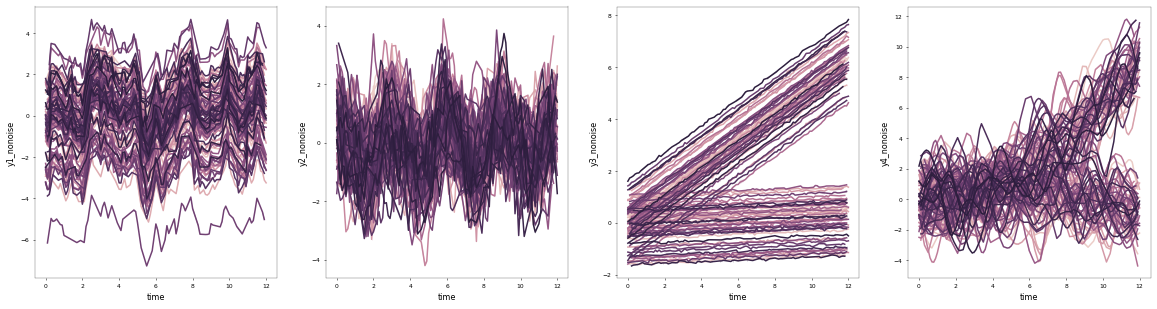

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), squeeze=False)
for i in range(4):
    sns.lineplot(x='time', 
                 y=[x for x in y_out[100].columns if x.startswith('y')][i], 
                 hue='id', 
                 data = y_out[100],
                 legend=False,
                 ax=axs[0,i])

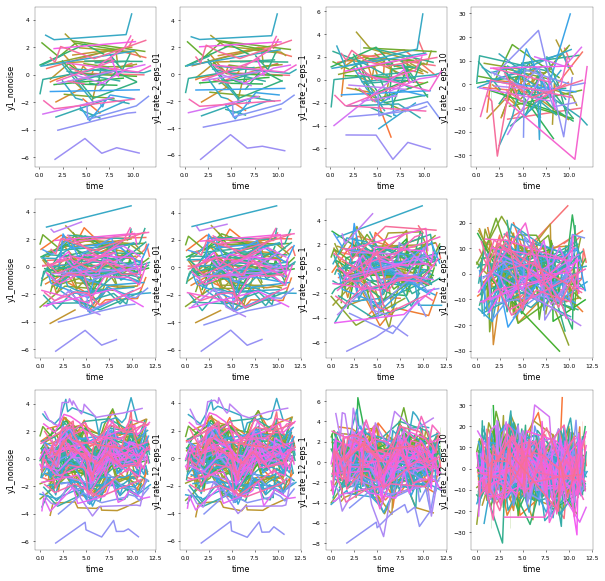

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10), squeeze=False)
for i in range(4):
    sns.lineplot(x='time', 
                 y=[x for x in y_out[2].columns if x.startswith('y1')][i], 
                 hue='id', 
                 data = y_out[2].assign(id = y_out[2].id.astype(str)),
                 legend=False,
                 ax=axs[0, i])
    sns.lineplot(x='time', 
                 y=[x for x in y_out[4].columns if x.startswith('y1')][i], 
                 hue='id', 
                 data = y_out[4].assign(id = y_out[4].id.astype(str)),
                 legend=False,
                 ax=axs[1, i])
    sns.lineplot(x='time', 
                 y=[x for x in y_out[12].columns if x.startswith('y1')][i], 
                 hue='id', 
                 data = y_out[12].assign(id = y_out[12].id.astype(str)),
                 legend=False,
                 ax=axs[2, i])


KeyError: 3

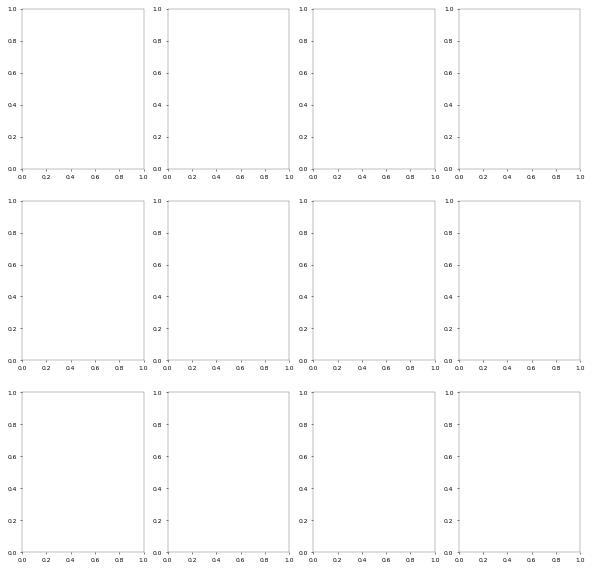

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10), squeeze=False)
for i in range(4):
    sns.lineplot(x='time', 
                 y=[x for x in y_out[3].columns if x.startswith('y4')][i], 
                 hue='id', 
                 data = y_out[3].assign(id = y_out[3].id.astype(str)),
                 legend=False,
                 ax=axs[0, i])
    sns.lineplot(x='time', 
                 y=[x for x in y_out[10].columns if x.startswith('y4')][i], 
                 hue='id', 
                 data = y_out[10].assign(id = y_out[10].id.astype(str)),
                 legend=False,
                 ax=axs[1, i])
    sns.lineplot(x='time', 
                 y=[x for x in y_out[30].columns if x.startswith('y4')][i], 
                 hue='id', 
                 data = y_out[30].assign(id = y_out[30].id.astype(str)),
                 legend=False,
                 ax=axs[2, i])


In [ ]:
sns.lineplot(x=y_out[30].time, y=y_out[30].y1_rate_30_eps_01, hue=y_out[30].id)


In [ ]:
sns.lineplot(x=y_out[30].time, y=y_out[30].y2_rate_30_eps_01, hue=y_out[30].id)

In [ ]:
sns.lineplot(x=y_out[30].time, y=y_out[30].y3_rate_30_eps_01, hue=y_out[30].id)

In [ ]:
sns.lineplot(x=y_out[30].time, y=y_out[30].y4_rate_30_eps_01, hue=y_out[30].id)